*Ref : https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79*

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np

## RNN with single neuron 

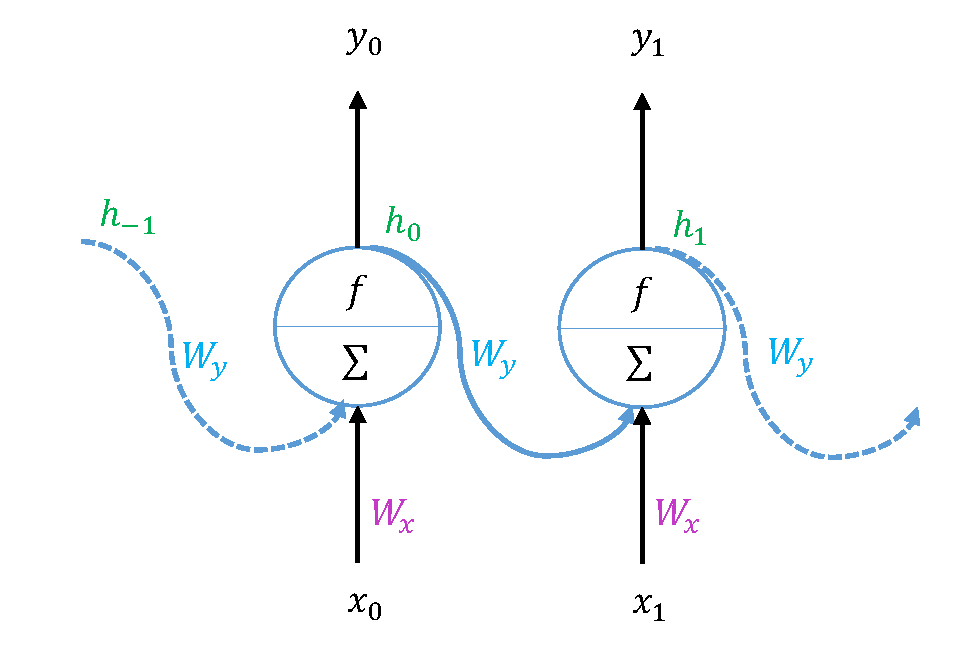


In [0]:
class SingleRNN(nn.Module):
  def __init__(self,n_inputs,n_neurons):
    super(SingleRNN,self).__init__()

    self.Wx=torch.randn(n_inputs,n_neurons) #4*1
    self.Wy=torch.randn(n_neurons,n_neurons) #1*1
    self.b = torch.zeros(1,n_neurons) #1*4

  def forward(self,X0,X1):
    self.Y0 = torch.tanh(torch.mm(X0,self.Wx) + self.b) #4*1
    self.Y1 = torch.tanh(torch.mm(X1,self.Wx) + self.b) #4*1
  
    return self.Y0,self.Y1

In the above code, I have implemented a simple one layer, one neuron RNN. I initialized two weight matrices, Wx and Wy with values from a normal distribution. Wxcontains connection weights for the inputs of the current time step, while Wy contains connection weights for the outputs of the previous time step. We also added a bias b. The forward function computes two outputs — one for each time step (two overall). Note that we are using tanh as the non-linearity (activation function) via torch.tanh(...).

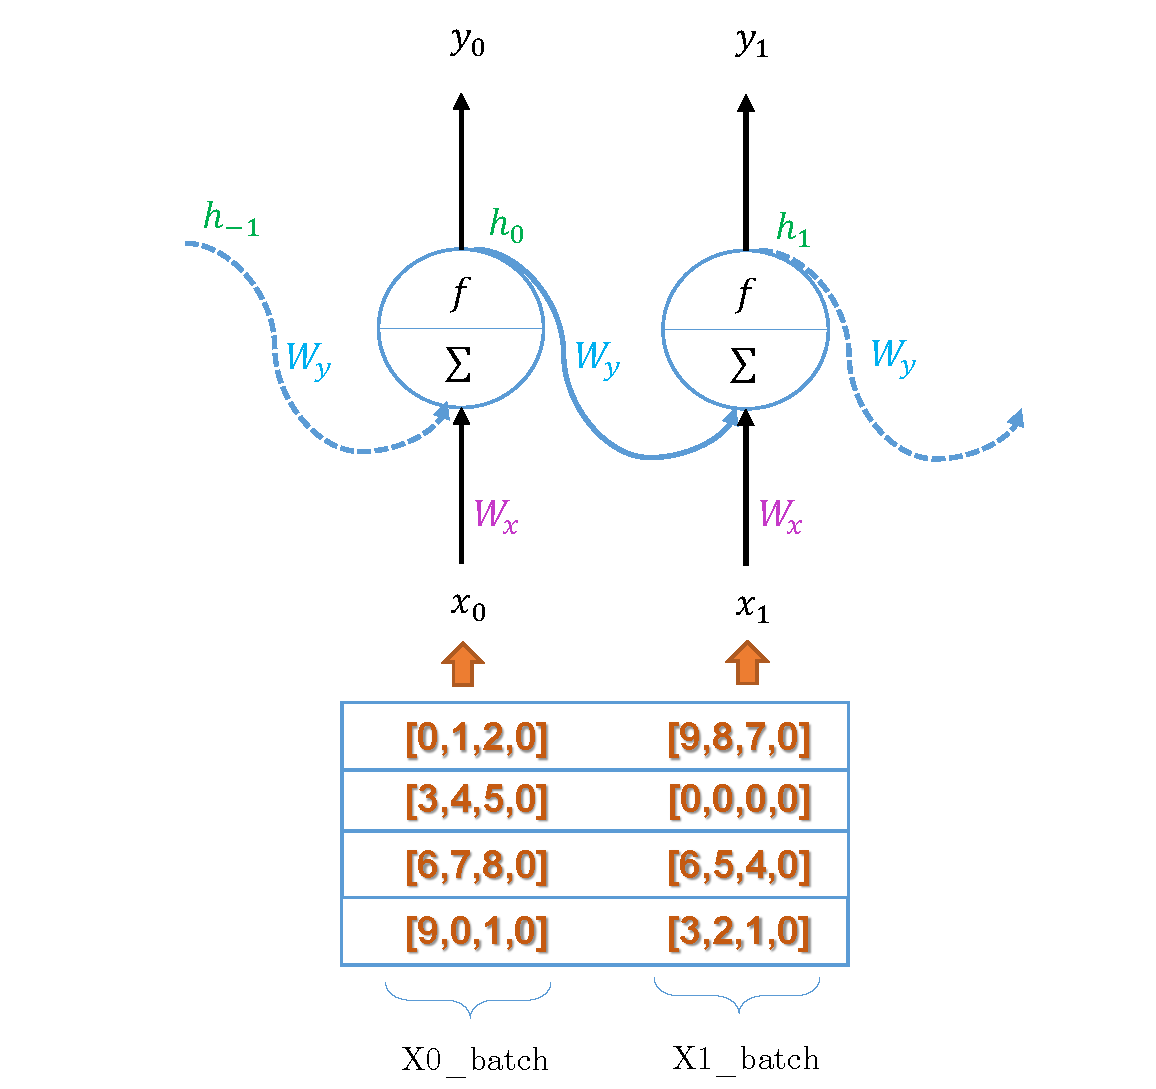

In [0]:
N_INPUT = 4
N_NEURONS = 1

X0_batch = torch.tensor([[0,1,2,0], [3,4,5,0], 
                         [6,7,8,0], [9,0,1,0]],
                        dtype = torch.float) #t=0 => 4 X 4

X1_batch = torch.tensor([[9,8,7,0], [0,0,0,0], 
                         [6,5,4,0], [3,2,1,0]],
                        dtype = torch.float) #t=1 => 4 X 4

model = SingleRNN(N_INPUT, N_NEURONS)

Y0_val, Y1_val = model(X0_batch, X1_batch)

In [4]:
Y0_val,Y1_val

(tensor([[-0.9314],
         [-1.0000],
         [-1.0000],
         [-1.0000]]), tensor([[-1.0000],
         [ 0.0000],
         [-1.0000],
         [-1.0000]]))

## RNN with multiple neurons

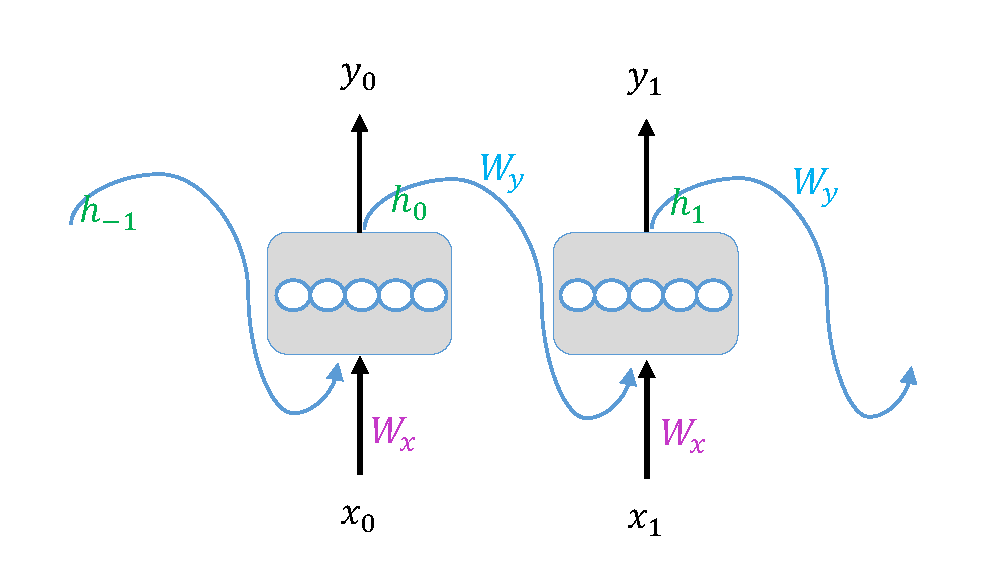

In [0]:
class BasicRNN(nn.Module):
  def __init__(self,n_inputs,n_neurons):
    super(BasicRNN,self).__init__()
    
    self.Wx = torch.randn(n_inputs,n_neurons)
    self.Wy = torch.randn(n_neurons,n_neurons)

    self.b = torch.zeros(1,n_neurons)

  def forward(self,X0,X1):
    self.Y0 = torch.tanh(torch.mm(X0,self.Wx) + self.b)
    self.Y1 = torch.tanh(torch.mm(X1,self.Wx) + self.b)

    return self.Y0,self.Y1

In [0]:

N_INPUT = 3 # number of features in input
N_NEURONS = 5 # number of units in layer

X0_batch = torch.tensor([[0,1,2], [3,4,5], 
                         [6,7,8], [9,0,1]],
                        dtype = torch.float) #t=0 => 4 X 3

X1_batch = torch.tensor([[9,8,7], [0,0,0], 
                         [6,5,4], [3,2,1]],
                        dtype = torch.float) #t=1 => 4 X 3

model = BasicRNN(N_INPUT, N_NEURONS)

Y0_val, Y1_val = model(X0_batch, X1_batch)

In [7]:
Y0_val

tensor([[ 0.9888,  0.8826, -0.8290, -0.6721, -0.9974],
        [ 1.0000,  1.0000, -1.0000, -1.0000, -1.0000],
        [ 1.0000,  1.0000, -1.0000, -1.0000, -1.0000],
        [-0.9979,  0.6405, -1.0000, -1.0000, -1.0000]])

If you take a closer look at the BasicRNN computation graph we have just built, it has a serious flaw. What if we wanted to build an architecture that supports extremely large inputs and outputs. The way it is currently built, it would require us to individually compute the outputs for every time step.

So now we use pytorch built in RNNCell

In [8]:
rnn = nn.RNNCell(3, 5) # n_input X n_neurons

X_batch = torch.tensor([[[0,1,2], [3,4,5], 
                         [6,7,8], [9,0,1]],
                        [[9,8,7], [0,0,0], 
                         [6,5,4], [3,2,1]]
                       ], dtype = torch.float) # X0 and X1

hx = torch.randn(4, 5) # m X n_neurons
output = []

# for each time step
for i in range(2):
    hx = rnn(X_batch[i], hx)
    output.append(hx)

print(output)

[tensor([[-0.0103,  0.9818, -0.5122, -0.3161,  0.8036],
        [-0.9941,  0.9991, -0.5059,  0.9548,  0.7928],
        [-0.9818,  1.0000, -0.9990,  0.9957,  0.9926],
        [-0.3583,  0.9914, -0.9976,  0.9964, -0.9733]], grad_fn=<TanhBackward>), tensor([[-0.9978,  1.0000, -0.9989,  0.9995,  0.6757],
        [ 0.6918,  0.3139,  0.0656, -0.7929,  0.3620],
        [-0.8735,  0.9997, -0.9752,  0.9489,  0.2319],
        [-0.6539,  0.9733, -0.1546, -0.0198, -0.5439]], grad_fn=<TanhBackward>)]


In [9]:
X_batch.shape

torch.Size([2, 4, 3])

In [10]:
class CleanBasicRNN(nn.Module):
    def __init__(self, batch_size, n_inputs, n_neurons):
        super(CleanBasicRNN, self).__init__()
        
        self.rnn = nn.RNNCell(n_inputs, n_neurons)
        self.hx = torch.randn(batch_size, n_neurons) # initialize hidden state
        
    def forward(self, X):
        output = []

        # for each time step
        for i in range(2):
            self.hx = self.rnn(X[i], self.hx)
            output.append(self.hx)
        
        return output, self.hx

FIXED_BATCH_SIZE = 4 # our batch size is fixed for now
N_INPUT = 3
N_NEURONS = 5

X_batch = torch.tensor([[[0,1,2], [3,4,5], 
                         [6,7,8], [9,0,1]],
                        [[9,8,7], [0,0,0], 
                         [6,5,4], [3,2,1]]
                       ], dtype = torch.float) # X0 and X1


model = CleanBasicRNN(FIXED_BATCH_SIZE, N_INPUT, N_NEURONS)
output_val, states_val = model(X_batch)
print(output_val) # contains all output for all timesteps
print(states_val) # contains values for final state or final timestep, i.e., t=1

[tensor([[-0.8219, -0.0742, -0.7939,  0.2414,  0.7083],
        [-0.9943,  0.0624, -0.7261, -0.5351,  0.8394],
        [-0.9475,  0.1424, -0.9862, -0.5709, -0.6719],
        [ 0.4969,  0.9986,  0.9984,  0.7918, -0.9748]], grad_fn=<TanhBackward>), tensor([[-0.6154,  0.8572, -0.8451, -0.3996, -0.8324],
        [ 0.0470, -0.3211, -0.7301,  0.3849, -0.4647],
        [-0.6734,  0.7176, -0.3489,  0.1445, -0.8030],
        [-0.6195,  0.8889,  0.4418, -0.1279,  0.6909]], grad_fn=<TanhBackward>)]
tensor([[-0.6154,  0.8572, -0.8451, -0.3996, -0.8324],
        [ 0.0470, -0.3211, -0.7301,  0.3849, -0.4647],
        [-0.6734,  0.7176, -0.3489,  0.1445, -0.8030],
        [-0.6195,  0.8889,  0.4418, -0.1279,  0.6909]], grad_fn=<TanhBackward>)


## RNN for Image Classification

In [11]:
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 64


# list all transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

# download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)



Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


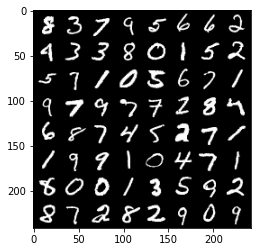

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))


dataiter = iter(trainloader)

images,labels = dataiter.next()

#show images
imshow(torchvision.utils.make_grid(images))

## Computation Graph for RNN


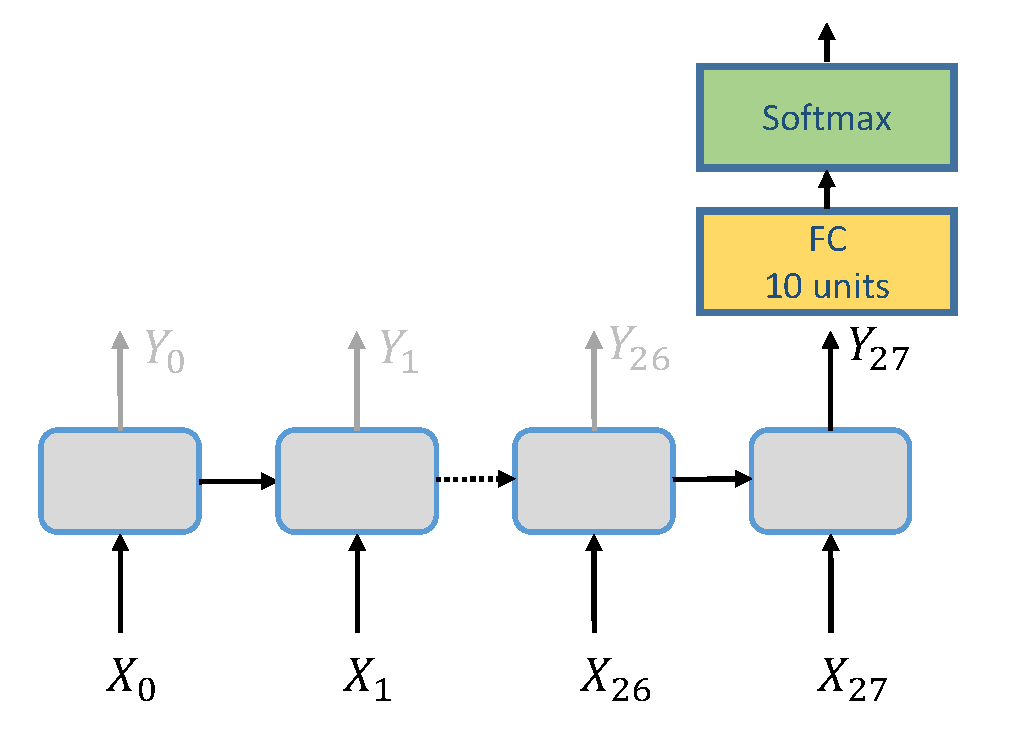

In [0]:
# parameters 
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 10

In [0]:

class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(ImageRNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

In [29]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
print(logits[0:10])


tensor([[-0.0440, -0.1301,  0.0177, -0.0354, -0.0333, -0.0618, -0.0481,  0.0958,
         -0.1395, -0.0031],
        [-0.0476, -0.1258,  0.0224, -0.0383, -0.0424, -0.0553, -0.0514,  0.1051,
         -0.1163, -0.0071],
        [-0.0630, -0.1173,  0.0207, -0.0362, -0.0320, -0.0444, -0.0567,  0.1006,
         -0.1189, -0.0047],
        [-0.0477, -0.1426,  0.0207, -0.0396, -0.0385, -0.0460, -0.0482,  0.1032,
         -0.1218, -0.0041],
        [-0.0447, -0.1467,  0.0179, -0.0477, -0.0381, -0.0484, -0.0537,  0.1070,
         -0.1270, -0.0015],
        [-0.0470, -0.1400,  0.0161, -0.0363, -0.0418, -0.0635, -0.0374,  0.0948,
         -0.1439, -0.0102],
        [-0.0348, -0.1558,  0.0154, -0.0456, -0.0458, -0.0559, -0.0402,  0.1072,
         -0.1349, -0.0180],
        [-0.0568, -0.1248,  0.0211, -0.0369, -0.0376, -0.0507, -0.0493,  0.1022,
         -0.1143, -0.0045],
        [-0.0435, -0.1419,  0.0211, -0.0385, -0.0444, -0.0493, -0.0491,  0.1030,
         -0.1184, -0.0026],
        [-0.0326, -

In [0]:
#train
import torch.optim as optim
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [37]:
for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.7543 | Train Accuracy: 75.60
Epoch:  1 | Loss: 0.3133 | Train Accuracy: 91.05
Epoch:  2 | Loss: 0.2172 | Train Accuracy: 93.84
Epoch:  3 | Loss: 0.1939 | Train Accuracy: 94.58
Epoch:  4 | Loss: 0.1706 | Train Accuracy: 95.19
Epoch:  5 | Loss: 0.1529 | Train Accuracy: 95.72
Epoch:  6 | Loss: 0.1392 | Train Accuracy: 96.21
Epoch:  7 | Loss: 0.1382 | Train Accuracy: 96.20
Epoch:  8 | Loss: 0.1264 | Train Accuracy: 96.58
Epoch:  9 | Loss: 0.1232 | Train Accuracy: 96.62


In [38]:

test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 96.94
